In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.special import expit, logit  # inv.logit is expit in Python; logit is its inverse function
from scipy.stats import norm, t as student_t
import statsmodels.api as sm
import re

## Creating Stan Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install cmdstanpy
!python -m cmdstanpy.install_cmdstan

<frozen runpy>:128: RuntimeWarning: 'cmdstanpy.install_cmdstan' found in sys.modules after import of package 'cmdstanpy', but prior to execution of 'cmdstanpy.install_cmdstan'; this may result in unpredictable behaviour
CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.36.0
Download successful, file: /tmp/tmpmfvdbbgn
Extracting distribution
Unpacked download as cmdstan-2.36.0
Building version cmdstan-2.36.0, may take several minutes, depending on your system.
Installed cmdstan-2.36.0
Test model compilation


In [14]:
from cmdstanpy import CmdStanModel
import os

# Ignore this -- todo: port stan code from the github (more complicated than the linzer model)
# Rewrite the provided Stan code with anchored delta[J] using transformed parameters

stan_code = """
data {
  int<lower=1> K;                    // number of polls
  int<lower=1> J;                    // number of campaign days
  int<lower=1> S;                    // number of states
  array[K] int<lower=1, upper=S> state; // state for each poll
  array[K] int<lower=1, upper=J> day;   // day for each poll
  array[K] int<lower=0> n;               // sample size of poll
  array[K] int<lower=0> y;               // number of dem supporters
  vector[S] h;                        // historical forecasts (h_i)
  vector[S] tau;                      // prior precision for each state (tau_i)
}
parameters {
  matrix[S, J] beta;                 // state-level support over time
  vector[J - 1] delta_raw;           // free parameters for national swing (J-1 values)
  real<lower=0> sigma_beta;          // variance of beta
  real<lower=0> sigma_delta;         // variance of delta
}
transformed parameters {
  vector[J] delta;
  for (j in 1:(J - 1))
    delta[j] = delta_raw[j];
  delta[J] = 0;  // anchor on Election Day
}
model {
  // Priors on beta and delta (reverse random walk from election day J)
  for (s in 1:S)
    beta[s, J] ~ normal(logit(h[s]), inv(sqrt(tau[s])));

  for (j in 1:(J - 1)) {
    for (s in 1:S)
      beta[s, j] ~ normal(beta[s, j + 1], sigma_beta);
    delta_raw[j] ~ normal(delta[j + 1], sigma_delta);
  }

  // Likelihood: poll observations
  for (k in 1:K) {
    real logit_pi = beta[state[k], day[k]] + delta[day[k]];
    y[k] ~ binomial_logit(n[k], logit_pi);
  }

  // Hyperpriors
  sigma_beta ~ normal(0, 0.2);
  sigma_delta ~ normal(0, 0.2);
}
generated quantities {
  matrix[S, J] pi;
  for (s in 1:S)
    for (j in 1:J)
      pi[s, j] = inv_logit(beta[s, j] + delta[j]);
}
"""

model_path = "/content/drive/MyDrive/poll_model.stan"
with open(model_path, "w") as f:
    f.write(stan_code)

model = CmdStanModel(stan_file=model_path)

DEBUG:cmdstanpy:Removing /content/drive/MyDrive/poll_model
00:55:47 - cmdstanpy - INFO - compiling stan file /content/drive/MyDrive/poll_model.stan to exe file /content/drive/MyDrive/poll_model
INFO:cmdstanpy:compiling stan file /content/drive/MyDrive/poll_model.stan to exe file /content/drive/MyDrive/poll_model
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=poll_model.stan /content/drive/MyDrive/poll_model
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=poll_model.stan --o=/content/drive/MyDrive/poll_model.hpp /content/drive/MyDrive/poll_model.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boos

# Test Stan model on generated data

In [15]:
import numpy as np

# Shared setup
np.random.seed(0)
S = 5       # number of states
J = 100      # number of days
K = int(2000/(12 * 30 * 50) * S * J)  # total polls per dataset -- match with Linzer? 2000 polls in 12 months for 50 states => 0.1 polls per state per day

tau = 5 * np.ones(S)
h = np.random.uniform(0.4, 0.6, size=S) # randomly set the final vote shares for each of the states
true_sigma_beta = 0.1
true_sigma_delta = 0.05

# Reverse random walk from election day
beta = np.zeros((S, J))
delta = np.zeros(J)
beta[:, -1] = np.random.normal(np.log(h / (1 - h)), 1 / np.sqrt(tau))
delta[-1] = 0  # anchor national support on election day

for j in reversed(range(J - 1)):
    beta[:, j] = beta[:, j + 1] + np.random.normal(0, true_sigma_beta, size=S)
    delta[j] = delta[j + 1] + np.random.normal(0, true_sigma_delta)

# TODO: Make another dataset using Linzer's assumptions (the number of polls increases closer to election day, and more polls in swing states)
# Dataset 1: all states well-polled
polls_per_state_1 = np.random.multinomial(K, [1 / S] * S)
state_idx_1, day_idx_1, n1 = [], [], []
for s in range(S):
    state_idx_1.extend([s] * polls_per_state_1[s])
    day_idx_1.extend(np.random.randint(0, J, size = polls_per_state_1[s]))
    n1.extend(np.random.randint(400, 1000, size = polls_per_state_1[s]))

state_idx_1 = np.array(state_idx_1)
day_idx_1 = np.array(day_idx_1)
logit_pi_1 = beta[state_idx_1, day_idx_1] + delta[day_idx_1]
pi_1 = 1 / (1 + np.exp(-logit_pi_1))
y1 = np.random.binomial(n1, pi_1)

test_data_1 = {
    "K": K,
    "J": J,
    "S": S,
    "state": (state_idx_1 + 1).tolist(),  # Stan uses 1-based indexing
    "day": (day_idx_1 + 1).tolist(),
    "n": list(n1),
    "y": y1.tolist(),
    "h": h.tolist(),
    "tau": tau.tolist(),
}

# Dataset 2: Some well-polled (states 0, 1, 2) and sparsely-polled (states 3, 4) states
sparse_states = [3, 4]
polls_sparse = max(1, int(K / (S * 3)))
polls_sparse_total = polls_sparse * len(sparse_states)
polls_remaining = K - polls_sparse_total

# Allocate remaining polls to well-polled states
allocated = np.random.multinomial(polls_remaining, [1 / 3] * 3)
polls_per_state_2 = {
    0: allocated[0],
    1: allocated[1],
    2: allocated[2],
    3: polls_sparse,
    4: polls_sparse,
}

state_idx_2, day_idx_2, n2 = [], [], []
for s in range(S):
    num_polls = polls_per_state_2[s]
    state_idx_2.extend([s] * num_polls)
    day_idx_2.extend(np.random.randint(0, J, size=num_polls))
    n2.extend(np.random.randint(400, 1000, size=num_polls))

state_idx_2 = np.array(state_idx_2)
day_idx_2 = np.array(day_idx_2)
logit_pi_2 = beta[state_idx_2, day_idx_2] + delta[day_idx_2]
pi_2 = 1 / (1 + np.exp(-logit_pi_2))
y2 = np.random.binomial(n2, pi_2)

test_data_2 = {
    "K": K,
    "J": J,
    "S": S,
    "state": (state_idx_2 + 1).tolist(),
    "day": (day_idx_2 + 1).tolist(),
    "n": list(n2),
    "y": y2.tolist(),
    "h": h.tolist(),
    "tau": tau.tolist(),
}

# Summary of poll allocation
import pandas as pd
poll_summary = pd.DataFrame({
    "State": [f"State {s}" for s in range(S)],
    "Dataset 1 (Well-Polled)": polls_per_state_1,
    "Dataset 2 (Sparse 3, Others Heavy)": [polls_per_state_2[s] for s in range(S)],
})
print(poll_summary)


fit_1 = model.sample(data=test_data_1, chains=4, iter_sampling=500, iter_warmup=500)
fit_2 = model.sample(data=test_data_2, chains=4, iter_sampling=500, iter_warmup=500)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import arviz as az

def plot_recovery_with_polls(
    fit, beta, delta, dataset_name, well_polled_states, sparse_states, poll_data
):
    pi_samples = fit.stan_variable("pi")  # shape: [draws, S, J]
    mean_pi = np.mean(pi_samples, axis=0)
    std_pi = np.std(pi_samples, axis=0)
    true_pi = 1 / (1 + np.exp(-(beta + delta[np.newaxis, :])))  # shape: (S, J)

    state_idx = np.array(poll_data["state"]) - 1
    day_idx = np.array(poll_data["day"]) - 1
    n = np.array(poll_data["n"])
    y = np.array(poll_data["y"])
    poll_pi = y / n

    # Colormaps
    cmap_well = cm.get_cmap("tab10")
    cmap_sparse = cm.get_cmap("Set2")

    plt.figure(figsize=(14, 8))
    for s in range(S):
        if s in well_polled_states:
            base_color = cmap_well(s % 10)
            label = f"State {s+1} (well-polled)"
        else:
            base_color = cmap_sparse(s % 8)
            label = f"State {s+1} (sparse)"

        # True and posterior
        darker_color = mcolors.to_rgba(base_color, alpha=0.9)
        lighter_color = mcolors.to_rgba(base_color, alpha=0.6)

        plt.plot(true_pi[s], '--', linewidth=1.2, color=darker_color)
        plt.plot(mean_pi[s], label=label, color=lighter_color)
        plt.fill_between(
            np.arange(J),
            mean_pi[s] - std_pi[s],
            mean_pi[s] + std_pi[s],
            color=lighter_color,
            alpha=0.2
        )

        # Polls
        poll_mask = (state_idx == s)
        plt.scatter(
            day_idx[poll_mask],
            poll_pi[poll_mask],
            color=base_color,
            alpha=0.3,
            edgecolor='k',
            s=20,
        )

    plt.xlabel("Day")
    plt.ylabel("Democratic vote share")
    plt.title(f"Posterior Recovery with Polls — {dataset_name}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Final-day comparison
    true_final_probs = 1 / (1 + np.exp(-(beta[:, -1] + delta[-1])))
    pred_final_probs = mean_pi[:, -1]
    print(f"\nElection Day Comparison — {dataset_name}")
    for s in range(S):
        print(f"State {s+1}: True = {true_final_probs[s]:.3f}, Predicted = {pred_final_probs[s]:.3f}")

    # Trace plots
    idata = az.from_cmdstanpy(posterior=fit)
    az.plot_trace(idata, var_names=["sigma_beta", "sigma_delta"])
    plt.suptitle(f"Trace Plots for {dataset_name}", y=1.02)
    plt.tight_layout()
    plt.show()

plot_recovery_with_polls(
    fit_1, beta, delta, "Dataset 1 (Well-Polled)",
    well_polled_states=[0, 1, 2, 3, 4], sparse_states=[],
    poll_data=test_data_1
)

plot_recovery_with_polls(
    fit_2, beta, delta, "Dataset 2 (Sparse+Heavy)",
    well_polled_states=[0, 1, 2], sparse_states=[3, 4],
    poll_data=test_data_2
)

     State  Dataset 1 (Well-Polled)  Dataset 2 (Sparse 3, Others Heavy)
0  State 0                        9                                  20
1  State 1                       12                                  15
2  State 2                        8                                  14
3  State 3                       18                                   3
4  State 4                        8                                   3


DEBUG:cmdstanpy:cmd: /content/drive/MyDrive/poll_model info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1v99qa0u/qqtfr13_.json
00:56:09 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/MyDrive/poll_model', 'id=1', 'random', 'seed=31801', 'data', 'file=/tmp/tmp1v99qa0u/qqtfr13_.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_modeltjn9eyxw/poll_model-20250508005609_1.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/MyDrive/poll_model', 'id=2', 'random', 'seed=31801', 'data', 'file=/tmp/tmp1v99qa0u/qqtfr13_.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_modeltjn9eyxw/poll_model-20250508005609_2.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/MyDrive/poll_model', 'id=3', 'random', 'seed=31801', 'data', 'file=/tmp/tmp1v99qa0u/qqtfr13

00:58:17 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/MyDrive/poll_model', 'id=1', 'random', 'seed=31801', 'data', 'file=/tmp/tmp1v99qa0u/qqtfr13_.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_modeltjn9eyxw/poll_model-20250508005609_1.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp1v99qa0u/poll_modeltjn9eyxw/poll_model-20250508005609_1.csv
 console_msgs (if any):
	/tmp/tmp1v99qa0u/poll_modeltjn9eyxw/poll_model-20250508005609_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 500
    num_warmup = 500
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
      gamma = 0.05 (Default)
      delta = 0.8 (Def

DEBUG:cmdstanpy:input tempfile: /tmp/tmp1v99qa0u/omuc_l97.json
00:58:17 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/MyDrive/poll_model', 'id=1', 'random', 'seed=79471', 'data', 'file=/tmp/tmp1v99qa0u/omuc_l97.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_modelkb1zvorh/poll_model-20250508005817_1.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/MyDrive/poll_model', 'id=2', 'random', 'seed=79471', 'data', 'file=/tmp/tmp1v99qa0u/omuc_l97.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_modelkb1zvorh/poll_model-20250508005817_2.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/MyDrive/poll_model', 'id=3', 'random', 'seed=79471', 'data', 'file=/tmp/tmp1v99qa0u/omuc_l9

01:00:56 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/MyDrive/poll_model', 'id=1', 'random', 'seed=79471', 'data', 'file=/tmp/tmp1v99qa0u/omuc_l97.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_modelkb1zvorh/poll_model-20250508005817_1.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp1v99qa0u/poll_modelkb1zvorh/poll_model-20250508005817_1.csv
 console_msgs (if any):
	/tmp/tmp1v99qa0u/poll_modelkb1zvorh/poll_model-20250508005817_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 500
    num_warmup = 500
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
      gamma = 0.05 (Default)
      delta = 0.8 (Def

In [18]:
# Re-import required libraries after kernel reset
import numpy as np

# These variables need to be redefined after kernel reset
# Assuming default true values used during data generation
true_sigma_beta = 0.1
true_sigma_delta = 0.05


sigma_beta_1 = fit_1.stan_variable("sigma_beta")
sigma_delta_1 = fit_1.stan_variable("sigma_delta")
sigma_beta_2 = fit_2.stan_variable("sigma_beta")
sigma_delta_2 = fit_2.stan_variable("sigma_delta")

# Compute posterior means and stds
posterior_mean_beta_1 = np.mean(sigma_beta_1)
posterior_std_beta_1 = np.std(sigma_beta_1)
posterior_mean_delta_1 = np.mean(sigma_delta_1)
posterior_std_delta_1 = np.std(sigma_delta_1)

posterior_mean_beta_2 = np.mean(sigma_beta_2)
posterior_std_beta_2 = np.std(sigma_beta_2)
posterior_mean_delta_2 = np.mean(sigma_delta_2)
posterior_std_delta_2 = np.std(sigma_delta_2)

# Print extended comparisons
print("=== Posterior Summary Comparison ===")
print(f"True sigma_beta = {true_sigma_beta:.3f}")
print(f"Dataset 1: Posterior mean = {posterior_mean_beta_1:.3f}, Std = {posterior_std_beta_1:.3f}")
print(f"Dataset 2: Posterior mean = {posterior_mean_beta_2:.3f}, Std = {posterior_std_beta_2:.3f}")
print()
print(f"True sigma_delta = {true_sigma_delta:.3f}")
print(f"Dataset 1: Posterior mean = {posterior_mean_delta_1:.3f}, Std = {posterior_std_delta_1:.3f}")
print(f"Dataset 2: Posterior mean = {posterior_mean_delta_2:.3f}, Std = {posterior_std_delta_2:.3f}")


=== Posterior Summary Comparison ===
True sigma_beta = 0.100
Dataset 1: Posterior mean = 0.131, Std = 0.018
Dataset 2: Posterior mean = 0.130, Std = 0.016

True sigma_delta = 0.050
Dataset 1: Posterior mean = 0.040, Std = 0.023
Dataset 2: Posterior mean = 0.055, Std = 0.029


# Prior Sensitivity Analysis for Report

In [38]:
# PRIOR SENSITIVITY EXPERIMENTS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import arviz as az
from cmdstanpy import CmdStanModel
import os

# -----------------------------
# SHARED SETUP
# -----------------------------
np.random.seed(0)
S, J = 5, 100
true_sigma_beta = 0.1
true_sigma_delta = 0.05

tau = 5 * np.ones(S)
h = np.random.uniform(0.4, 0.6, size=S)

# Generate true latent beta and delta
beta = np.zeros((S, J))
delta = np.zeros(J)
beta[:, -1] = np.random.normal(np.log(h / (1 - h)), 1 / np.sqrt(tau))
delta[-1] = 0
for j in reversed(range(J - 1)):
    beta[:, j] = beta[:, j + 1] + np.random.normal(0, true_sigma_beta, size=S)
    delta[j] = delta[j + 1] + np.random.normal(0, true_sigma_delta)

true_pi = 1 / (1 + np.exp(-(beta + delta[np.newaxis, :])))

# -----------------------------
# DEFINE STAN TEMPLATE
# -----------------------------
stan_template = """
data {{
  int<lower=1> K;
  int<lower=1> J;
  int<lower=1> S;
  array[K] int<lower=1, upper=S> state;
  array[K] int<lower=1, upper=J> day;
  array[K] int<lower=0> n;
  array[K] int<lower=0> y;
  vector[S] h;
  vector[S] tau;
}}
parameters {{
  matrix[S, J] beta;
  vector[J - 1] delta_raw;
  real<lower=0> sigma_beta;
  real<lower=0> sigma_delta;
}}
transformed parameters {{
  vector[J] delta;
  for (j in 1:(J - 1))
    delta[j] = delta_raw[j];
  delta[J] = 0;
}}
model {{
  for (s in 1:S)
    beta[s, J] ~ normal(logit(h[s]), inv(sqrt(tau[s])));
  for (j in 1:(J - 1)) {{
    for (s in 1:S)
      beta[s, j] ~ normal(beta[s, j + 1], sigma_beta);
    delta_raw[j] ~ normal(delta[j + 1], sigma_delta);
  }}
  for (k in 1:K) {{
    real logit_pi = beta[state[k], day[k]] + delta[day[k]];
    y[k] ~ binomial_logit(n[k], logit_pi);
  }}
  {priors}
}}
generated quantities {{
  matrix[S, J] pi;
  for (s in 1:S)
    for (j in 1:J)
      pi[s, j] = inv_logit(beta[s, j] + delta[j]);
}}
"""

prior_variants = {
    "normal_005": "sigma_beta ~ normal(0, 0.05);\nsigma_delta ~ normal(0, 0.05);",
    "normal_02": "sigma_beta ~ normal(0, 0.2);\nsigma_delta ~ normal(0, 0.2);",
    "normal_05": "sigma_beta ~ normal(0, 0.5);\nsigma_delta ~ normal(0, 0.5);"
}

compiled_models = {}
for name, prior_code in prior_variants.items():
    model_code = stan_template.format(priors=prior_code)
    stan_path = f"poll_model_{name}.stan"
    with open(stan_path, "w") as f:
        f.write(model_code)
    compiled_models[name] = CmdStanModel(stan_file=stan_path)

# -----------------------------
# DATASET GENERATION
# -----------------------------
def generate_dataset():
    """
    Match Linzer's rate of ~0.11 polls/state/day (2000 polls in 12 months for 50 states).
    Scaled to 5 states over 100 days is around 55 total polls.
    """
    K = int((2000 / (12 * 30 * 50)) * S * J)
    polls = np.random.multinomial(K, [1 / S] * S)

    state_idx, day_idx, n = [], [], []
    for s in range(S):
        state_idx.extend([s] * polls[s])
        day_idx.extend(np.random.randint(0, J, size=polls[s]))
        n.extend(np.random.randint(400, 1000, size=polls[s]))

    state_idx = np.array(state_idx)
    day_idx = np.array(day_idx)
    pi = 1 / (1 + np.exp(-(beta[state_idx, day_idx] + delta[day_idx])))
    y = np.random.binomial(n, pi)

    return {
        "K": len(y), "J": J, "S": S,
        "state": (state_idx + 1).tolist(),
        "day": (day_idx + 1).tolist(),
        "n": list(n), "y": y.tolist(),
        "h": h.tolist(), "tau": tau.tolist()
    }

def generate_sparse_dataset():
    """
    Generate a uniformly sparse dataset with 0.02 polls/state/day,
    totaling ~10 polls across all states.
    """
    K_sparse = int(0.02 * S * J)  # Very sparse
    polls = np.random.multinomial(K_sparse, [1 / S] * S)

    state_idx, day_idx, n = [], [], []
    for s in range(S):
        state_idx.extend([s] * polls[s])
        day_idx.extend(np.random.randint(0, J, size=polls[s]))
        n.extend(np.random.randint(400, 1000, size=polls[s]))

    state_idx = np.array(state_idx)
    day_idx = np.array(day_idx)
    pi = 1 / (1 + np.exp(-(beta[state_idx, day_idx] + delta[day_idx])))
    y = np.random.binomial(n, pi)

    return {
        "K": len(y), "J": J, "S": S,
        "state": (state_idx + 1).tolist(),
        "day": (day_idx + 1).tolist(),
        "n": list(n), "y": y.tolist(),
        "h": h.tolist(), "tau": tau.tolist()
    }

# -----------------------------
# EVALUATION & PLOTTING
# -----------------------------
def evaluate_sensitivity(fit_results, beta, delta, sparse_states, well_polled_states):
    true_pi = 1 / (1 + np.exp(-(beta + delta[np.newaxis, :])))
    election_day = -1
    summary_df = pd.DataFrame(columns=["Prior", "RMSE", "Sparse Std", "Well Std"])

    for name, fit in fit_results.items():
        pi_samples = fit.stan_variable("pi")
        mean_pi = np.mean(pi_samples, axis=0)
        std_pi = np.std(pi_samples, axis=0)

        rmse = np.sqrt(np.mean((mean_pi[:, election_day] - true_pi[:, election_day]) ** 2))
        sparse_std = np.mean(std_pi[sparse_states])
        well_std = np.mean(std_pi[well_polled_states])

        summary_df = pd.concat([summary_df, pd.DataFrame([{
            "Prior": name,
            "RMSE": rmse,
            "Sparse Std": sparse_std,
            "Well Std": well_std
        }])], ignore_index=True)

    return summary_df

def plot_summary(summary_df):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
    axs[0].bar(summary_df["Prior"], summary_df["RMSE"], color='steelblue')
    axs[0].set_title("RMSE on Election Day")
    axs[1].bar(summary_df["Prior"], summary_df["Sparse Std"], color='orange')
    axs[1].set_title("Std Dev (Sparse States)")
    axs[2].bar(summary_df["Prior"], summary_df["Well Std"], color='green')
    axs[2].set_title("Std Dev (Well-Polled States)")
    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.tick_params(axis='x', rotation=45)
    plt.suptitle("Prior Sensitivity Summary", fontsize=16)
    plt.tight_layout()
    plt.show()
def plot_trajectories(fit_results, beta, delta, states_to_plot, poll_data):
    fig, axs = plt.subplots(1, len(fit_results), figsize=(7 * len(fit_results), 5), sharey=True)
    colors = cm.get_cmap("tab10")
    true_pi = 1 / (1 + np.exp(-(beta + delta[np.newaxis, :])))

    state_idx = np.array(poll_data["state"]) - 1
    day_idx = np.array(poll_data["day"]) - 1
    y = np.array(poll_data["y"])
    n = np.array(poll_data["n"])
    poll_pi = y / n

    for i, (name, fit) in enumerate(fit_results.items()):
        pi_samples = fit.stan_variable("pi")
        mean_pi = np.mean(pi_samples, axis=0)
        std_pi = np.std(pi_samples, axis=0)
        ax = axs[i]

        for idx, s in enumerate(states_to_plot):
            base_color = colors(idx)
            # Plot true and posterior mean with uncertainty
            ax.plot(true_pi[s], '--', label=f"True S{s}", color=base_color)
            ax.plot(mean_pi[s], label=f"Pred S{s}", color=base_color, alpha=0.7)
            ax.fill_between(np.arange(J), mean_pi[s] - std_pi[s], mean_pi[s] + std_pi[s],
                            color=base_color, alpha=0.2)

            # Add polling data as circles
            mask = (state_idx == s)
            ax.scatter(day_idx[mask], poll_pi[mask],
                       facecolors='none', edgecolors=base_color, s=30, label=f"Polls S{s}", alpha=0.6)

        ax.set_title(f"Prior: {name}")
        ax.set_xlabel("Day")
        ax.grid(True)
        ax.legend()

    axs[0].set_ylabel("Democratic vote share")
    plt.suptitle("Posterior Recovery with Poll Data", fontsize=16)
    plt.tight_layout()
    plt.show()



DEBUG:cmdstanpy:Removing /content/poll_model_normal_005
02:16:55 - cmdstanpy - INFO - compiling stan file /content/poll_model_normal_005.stan to exe file /content/poll_model_normal_005
INFO:cmdstanpy:compiling stan file /content/poll_model_normal_005.stan to exe file /content/poll_model_normal_005
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=poll_model_normal_005.stan /content/poll_model_normal_005
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=poll_model_normal_005.stan --o=/content/poll_model_normal_005.hpp /content/poll_model_normal_005.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_

In [42]:
def count_polls_per_state(poll_data, S=5):
    """
    Returns a pandas Series with the number of polls per state.

    Parameters:
        poll_data (dict): Stan-formatted data dict with key 'state' (1-indexed).
        S (int): Total number of states.

    Returns:
        pd.Series: Poll counts for each state labeled as 'State 0', ..., 'State S-1'.
    """
    state_idx = np.array(poll_data["state"]) - 1  # convert to 0-based
    counts = np.bincount(state_idx, minlength=S)
    return pd.Series(counts, index=[f"State {i}" for i in range(S)], name="Num Polls")

data_exp1 = generate_dataset()
data_exp2 = generate_sparse_dataset()

# Count polls per state for actual data_exp1 and data_exp2
poll_counts_exp1 = count_polls_per_state(data_exp1)
poll_counts_exp2 = count_polls_per_state(data_exp2)

# Combine into summary table
poll_summary_actual = pd.concat([poll_counts_exp1, poll_counts_exp2], axis=1)
poll_summary_actual.columns = ["Experiment 1", "Experiment 2"]
print(poll_summary_actual)

         Experiment 1  Experiment 2
State 0            11             2
State 1            17             2
State 2             7             1
State 3             5             2
State 4            15             3


DEBUG:cmdstanpy:cmd: /content/poll_model_normal_005 info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1v99qa0u/qwexxq6o.json
02:18:24 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/poll_model_normal_005', 'id=1', 'random', 'seed=7467', 'data', 'file=/tmp/tmp1v99qa0u/qwexxq6o.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_model_normal_005rko_axqa/poll_model_normal_005-20250508021825_1.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/poll_model_normal_005', 'id=2', 'random', 'seed=7467', 'data', 'file=/tmp/tmp1v99qa0u/qwexxq6o.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_model_normal_005rko_axqa/poll_model_normal_005-20250508021825_2.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/poll_model_normal_005', 'id=3', 'random', 'seed=7467', 'data'

02:20:36 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/poll_model_normal_005', 'id=1', 'random', 'seed=7467', 'data', 'file=/tmp/tmp1v99qa0u/qwexxq6o.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_model_normal_005rko_axqa/poll_model_normal_005-20250508021825_1.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp1v99qa0u/poll_model_normal_005rko_axqa/poll_model_normal_005-20250508021825_1.csv
 console_msgs (if any):
	/tmp/tmp1v99qa0u/poll_model_normal_005rko_axqa/poll_model_normal_005-20250508021825_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 500
    num_warmup = 500
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/poll_model_normal_02', 'id=2', 'random', 'seed=19637', 'data', 'file=/tmp/tmp1v99qa0u/39un_pm9.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_model_normal_02w_6k15o6/poll_model_normal_02-20250508022036_2.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:CmdStan args: ['/content/poll_model_normal_02', 'id=1', 'random', 'seed=19637', 'data', 'file=/tmp/tmp1v99qa0u/39un_pm9.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_model_normal_02w_6k15o6/poll_model_normal_02-20250508022036_1.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/poll_model_normal_02', 'id=3', 'random', 'seed=19637', 'data', 'f

02:22:53 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/poll_model_normal_02', 'id=1', 'random', 'seed=19637', 'data', 'file=/tmp/tmp1v99qa0u/39un_pm9.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_model_normal_02w_6k15o6/poll_model_normal_02-20250508022036_1.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp1v99qa0u/poll_model_normal_02w_6k15o6/poll_model_normal_02-20250508022036_1.csv
 console_msgs (if any):
	/tmp/tmp1v99qa0u/poll_model_normal_02w_6k15o6/poll_model_normal_02-20250508022036_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 500
    num_warmup = 500
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Defa

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/poll_model_normal_05', 'id=1', 'random', 'seed=736', 'data', 'file=/tmp/tmp1v99qa0u/_2phem83.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_model_normal_05t6mk7i8q/poll_model_normal_05-20250508022253_1.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/poll_model_normal_05', 'id=2', 'random', 'seed=736', 'data', 'file=/tmp/tmp1v99qa0u/_2phem83.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_model_normal_05t6mk7i8q/poll_model_normal_05-20250508022253_2.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/poll_model_normal_05', 'id=3', 'random', 'seed=736', 'data', 'file=/t

02:25:18 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/poll_model_normal_05', 'id=1', 'random', 'seed=736', 'data', 'file=/tmp/tmp1v99qa0u/_2phem83.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_model_normal_05t6mk7i8q/poll_model_normal_05-20250508022253_1.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp1v99qa0u/poll_model_normal_05t6mk7i8q/poll_model_normal_05-20250508022253_1.csv
 console_msgs (if any):
	/tmp/tmp1v99qa0u/poll_model_normal_05t6mk7i8q/poll_model_normal_05-20250508022253_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 500
    num_warmup = 500
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Defaul

<ipython-input-38-065e49dacb43>:171: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_df = pd.concat([summary_df, pd.DataFrame([{


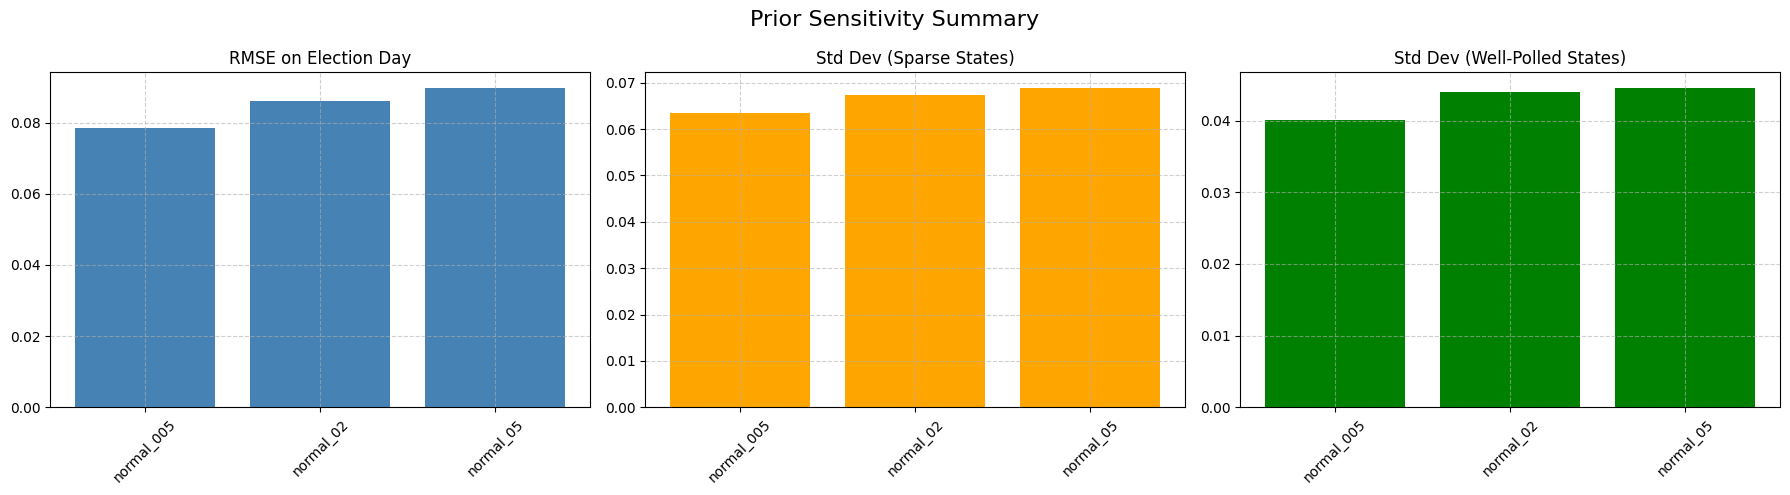

<ipython-input-38-065e49dacb43>:196: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("tab10")


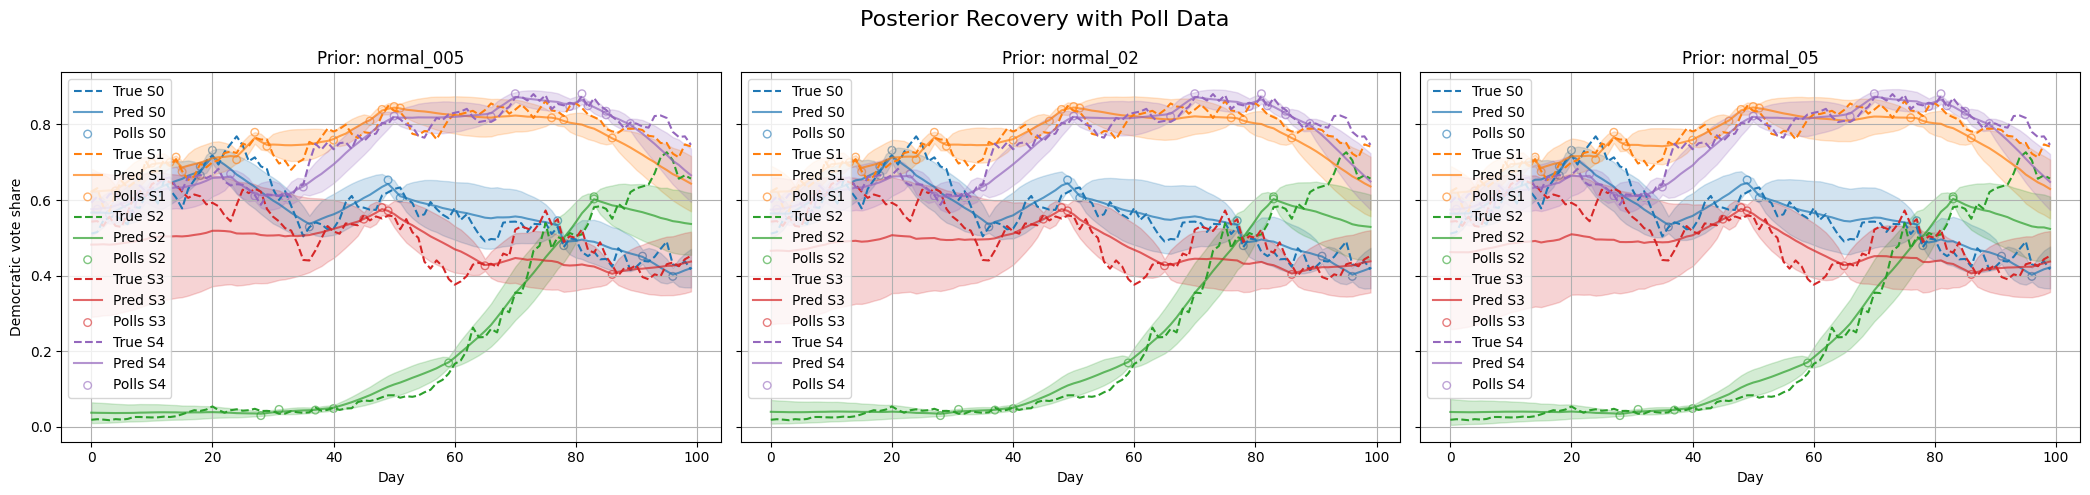

DEBUG:cmdstanpy:cmd: /content/poll_model_normal_005 info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1v99qa0u/wf5htv8_.json
02:25:22 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/poll_model_normal_005', 'id=1', 'random', 'seed=37938', 'data', 'file=/tmp/tmp1v99qa0u/wf5htv8_.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_model_normal_005lxcxdk4d/poll_model_normal_005-20250508022522_1.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/poll_model_normal_005', 'id=2', 'random', 'seed=37938', 'data', 'file=/tmp/tmp1v99qa0u/wf5htv8_.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_model_normal_005lxcxdk4d/poll_model_normal_005-20250508022522_2.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/poll_model_normal_005', 'id=3', 'random', 'seed=37938', 'da

02:28:48 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/poll_model_normal_005', 'id=1', 'random', 'seed=37938', 'data', 'file=/tmp/tmp1v99qa0u/wf5htv8_.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_model_normal_005lxcxdk4d/poll_model_normal_005-20250508022522_1.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp1v99qa0u/poll_model_normal_005lxcxdk4d/poll_model_normal_005-20250508022522_1.csv
 console_msgs (if any):
	/tmp/tmp1v99qa0u/poll_model_normal_005lxcxdk4d/poll_model_normal_005-20250508022522_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 500
    num_warmup = 500
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = tru

02:28:49 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 168 iterations at max treedepth (33.6%)
	Chain 2 had 385 iterations at max treedepth (77.0%)
	Chain 3 had 455 iterations at max treedepth (91.0%)
	Chain 4 had 471 iterations at max treedepth (94.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
	Chain 1 had 168 iterations at max treedepth (33.6%)
	Chain 2 had 385 iterations at max treedepth (77.0%)
	Chain 3 had 455 iterations at max treedepth (91.0%)
	Chain 4 had 471 iterations at max treedepth (94.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
DEBUG:cmdstanpy:cmd: /content/poll_model_normal_02 info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1v99qa0u/zjot0mea.json
02:28:49 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/poll_model_normal_02', 'id=1', 'random', 'seed=15773', 'data', 'file=/tmp/tmp1v99qa0u/zjot0mea.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_model_normal_02gjz2nt3e/poll_model_normal_02-20250508022849_1.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/poll_model_normal_02', 'id=2', 'random', 'seed=15773', 'data', 'file=/tmp/tmp1v99qa0u/zjot0mea.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_model_normal_02gjz2nt3e/poll_model_normal_02-20250508022849_2.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/poll_model_normal_02', 'id=3', 'random', 'seed=15773', 'data', 'f

02:31:14 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/poll_model_normal_02', 'id=1', 'random', 'seed=15773', 'data', 'file=/tmp/tmp1v99qa0u/zjot0mea.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_model_normal_02gjz2nt3e/poll_model_normal_02-20250508022849_1.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp1v99qa0u/poll_model_normal_02gjz2nt3e/poll_model_normal_02-20250508022849_1.csv
 console_msgs (if any):
	/tmp/tmp1v99qa0u/poll_model_normal_02gjz2nt3e/poll_model_normal_02-20250508022849_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 500
    num_warmup = 500
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Defa

02:31:15 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 26 iterations at max treedepth (5.2%)
	Chain 2 had 1 divergent transitions (0.2%)
	Chain 2 had 70 iterations at max treedepth (14.0%)
	Chain 3 had 73 iterations at max treedepth (14.6%)
	Chain 4 had 14 iterations at max treedepth (2.8%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
	Chain 1 had 26 iterations at max treedepth (5.2%)
	Chain 2 had 1 divergent transitions (0.2%)
	Chain 2 had 70 iterations at max treedepth (14.0%)
	Chain 3 had 73 iterations at max treedepth (14.6%)
	Chain 4 had 14 iterations at max treedepth (2.8%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
DEBUG:cmdstanpy:cmd: /content/poll_model_normal_05 info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1v99qa0u/wrg058fq.json
02:31:15 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/poll_model_normal_05', 'id=1', 'random', 'seed=29841', 'data', 'file=/tmp/tmp1v99qa0u/wrg058fq.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_model_normal_05l8vm_06k/poll_model_normal_05-20250508023115_1.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/poll_model_normal_05', 'id=2', 'random', 'seed=29841', 'data', 'file=/tmp/tmp1v99qa0u/wrg058fq.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_model_normal_05l8vm_06k/poll_model_normal_05-20250508023115_2.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/poll_model_normal_05', 'id=3', 'random', 'seed=29841', 'data', 'f

02:34:11 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/poll_model_normal_05', 'id=1', 'random', 'seed=29841', 'data', 'file=/tmp/tmp1v99qa0u/wrg058fq.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_model_normal_05l8vm_06k/poll_model_normal_05-20250508023115_1.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp1v99qa0u/poll_model_normal_05l8vm_06k/poll_model_normal_05-20250508023115_1.csv
 console_msgs (if any):
	/tmp/tmp1v99qa0u/poll_model_normal_05l8vm_06k/poll_model_normal_05-20250508023115_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 500
    num_warmup = 500
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Defa

02:34:11 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 59 iterations at max treedepth (11.8%)
	Chain 2 had 471 iterations at max treedepth (94.2%)
	Chain 3 had 105 iterations at max treedepth (21.0%)
	Chain 4 had 41 iterations at max treedepth (8.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
	Chain 1 had 59 iterations at max treedepth (11.8%)
	Chain 2 had 471 iterations at max treedepth (94.2%)
	Chain 3 had 105 iterations at max treedepth (21.0%)
	Chain 4 had 41 iterations at max treedepth (8.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
<ipython-input-38-065e49dacb43>:171: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_d

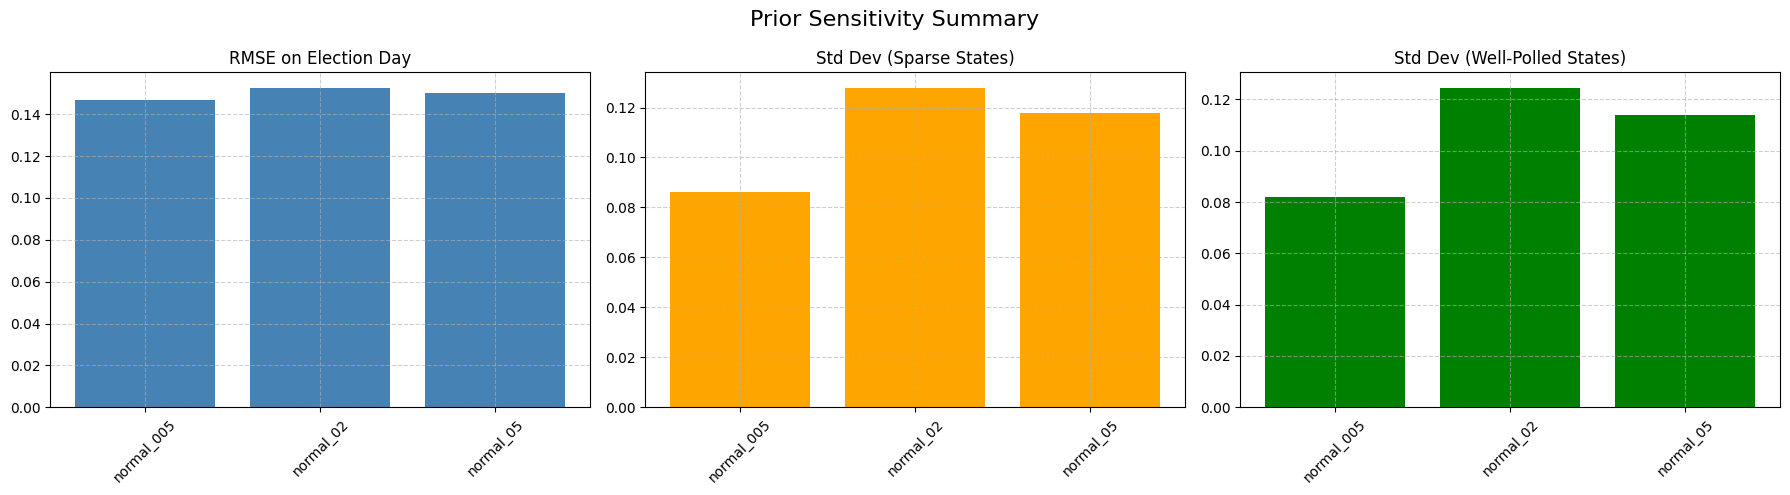

<ipython-input-38-065e49dacb43>:196: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("tab10")


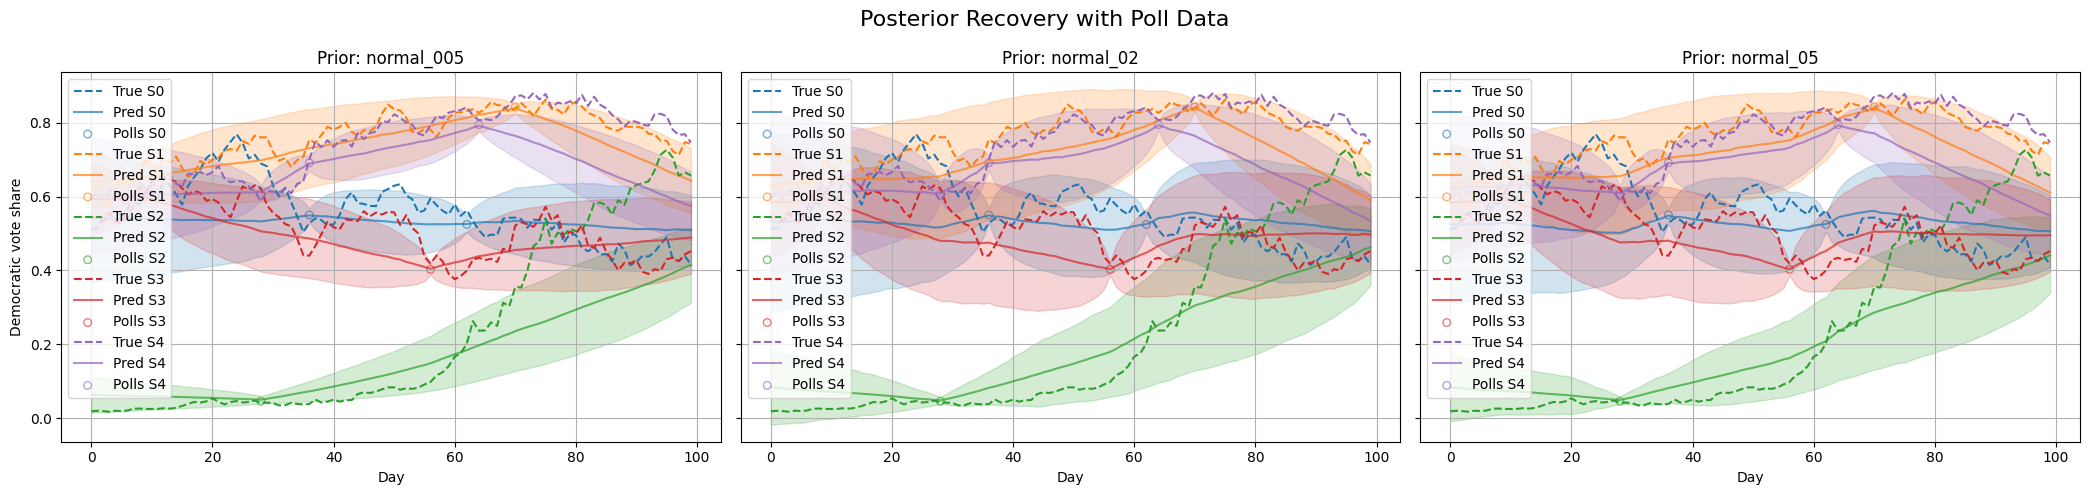

In [43]:

# -----------------------------
# RUNNING THE EXPERIMENTS
# -----------------------------
# EXPERIMENT 1: Mixed polling structure
fit_results_exp1 = {name: model.sample(data=data_exp1, chains=4, iter_sampling=500, iter_warmup=500)
                    for name, model in compiled_models.items()}
summary_exp1 = evaluate_sensitivity(fit_results_exp1, beta, delta, sparse_states=[3, 4], well_polled_states=[0, 1, 2])
plot_summary(summary_exp1)
plot_trajectories(fit_results_exp1, beta, delta, states_to_plot=[0, 1, 2, 3, 4], poll_data=data_exp1)

# EXPERIMENT 2: Very sparse polling
fit_results_exp2 = {name: model.sample(data=data_exp2, chains=4, iter_sampling=500, iter_warmup=500)
                    for name, model in compiled_models.items()}
summary_exp2 = evaluate_sensitivity(fit_results_exp2, beta, delta, sparse_states=[3, 4], well_polled_states=[0, 1, 2])
plot_summary(summary_exp2)
plot_trajectories(fit_results_exp2, beta, delta, states_to_plot=[0, 1, 2, 3, 4], poll_data=data_exp2)

# Updated Kremp Model

From https://www.slate.com/features/pkremp_forecast/report.html

In [58]:
import numpy as np
import pandas as pd
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import arviz as az
import os

# Constants
np.random.seed(0)
S = 5       # Number of states
T = 100     # Number of days
P = 5       # Number of pollsters
K = int(2000 / (12 * 30 * 50) * S * T)  # Total polls

# Priors
tau = 5 * np.ones(S)
h = np.random.uniform(0.4, 0.6, size=S)
true_sigma_a = 0.015
true_sigma_b = 0.02
true_sigma_c = 0.03
true_sigma_e = 0.01

# Latent variables
mu_a = np.zeros(T)
mu_b = np.zeros((T, S))
mu_c = np.random.normal(0, true_sigma_c, size=P)
e = np.random.normal(0, true_sigma_e, size=S)

mu_a[-1] = 0
mu_b[-1] = np.log(h / (1 - h))

for t in reversed(range(T - 1)):
    mu_a[t] = mu_a[t + 1] + np.random.normal(0, true_sigma_a)
    mu_b[t] = mu_b[t + 1] + np.random.normal(0, true_sigma_b, size=S)

# Polls
polls_per_state = np.random.multinomial(K, [1 / S] * S)
state_idx, day_idx, pollster_idx, n = [], [], [], []

for s in range(S):
    count = polls_per_state[s]
    state_idx.extend([s] * count)
    day_idx.extend(np.random.randint(0, T, size=count))
    pollster_idx.extend(np.random.randint(0, P, size=count))
    n.extend(np.random.randint(400, 1000, size=count))

state_idx = np.array(state_idx)
day_idx = np.array(day_idx)
pollster_idx = np.array(pollster_idx)
n = np.array(n)

logit_pi = mu_a[day_idx] + mu_b[day_idx, state_idx] + mu_c[pollster_idx] + e[state_idx]
pi = 1 / (1 + np.exp(-logit_pi))
y = np.random.binomial(n, pi)

# Stan data dictionary
stan_data = {
    "K": len(y),
    "T": T,
    "S": S,
    "P": P,
    "state": (state_idx + 1).tolist(),
    "day": (day_idx + 1).tolist(),
    "pollster": (pollster_idx + 1).tolist(),
    "n": list(n),
    "y": list(y),
    "h": h.tolist(),
    "tau": tau.tolist()
}

# Save Stan model code
stan_code = """
data {
  int<lower=1> K;
  int<lower=1> T;
  int<lower=1> S;
  int<lower=1> P;
  array[K] int<lower=1, upper=S> state;
  array[K] int<lower=1, upper=T> day;
  array[K] int<lower=1, upper=P> pollster;
  array[K] int<lower=0> n;
  array[K] int<lower=0> y;
  vector[S] h;
  vector[S] tau;
}
parameters {
  vector[T - 1] mu_a_raw;
  matrix[T - 1, S] mu_b_raw;
  vector[S] e;
  vector[P] mu_c;
  real<lower=1e-6> sigma_a;
  real<lower=1e-6> sigma_b;
  real<lower=1e-6> sigma_c;
  real<lower=1e-6> sigma_e;
}
transformed parameters {
  vector[T] mu_a;
  matrix[T, S] mu_b;
  mu_a[T] = 0;
  for (t in 1:(T - 1))
    mu_a[t] = mu_a_raw[t];
  for (s in 1:S) {
    mu_b[T, s] = logit(h[s]);
    for (t in 1:(T - 1))
      mu_b[t, s] = mu_b_raw[t, s];
  }
}
model {
  sigma_a ~ normal(0, 0.2);
  sigma_b ~ normal(0, 0.2);
  sigma_c ~ normal(0, 0.2);
  sigma_e ~ normal(0, 0.2);
  mu_c ~ normal(0, sigma_c);
  e ~ normal(0, sigma_e);
  for (t in 1:(T - 1))
    mu_a[t] ~ normal(mu_a[t + 1], sigma_a);
  for (s in 1:S)
    for (t in 1:(T - 1))
      mu_b[t, s] ~ normal(mu_b[t + 1, s], sigma_b);
  for (k in 1:K) {
    real logit_pi = mu_a[day[k]] + mu_b[day[k], state[k]] + mu_c[pollster[k]] + e[state[k]];
    y[k] ~ binomial_logit(n[k], logit_pi);
  }
}
generated quantities {
  matrix[S, T] pi;
  for (s in 1:S)
    for (t in 1:T)
      pi[s, t] = inv_logit(mu_a[t] + mu_b[t, s] + e[s]);
}
"""
with open("poll_model_kremp.stan", "w") as f:
    f.write(stan_code)

# Compile model
kremp_model = CmdStanModel(stan_file="poll_model_kremp.stan")

# Sample
# fit = model.sample(data=stan_data, chains=4, iter_sampling=500, iter_warmup=500)

# Return outputs for plotting
pi_samples = fit.stan_variable("pi")
mean_pi = np.mean(pi_samples, axis=0)
std_pi = np.std(pi_samples, axis=0)
true_pi = 1 / (1 + np.exp(-(mu_a[None, :] + mu_b.T + e[:, None])))

print(pd.DataFrame({
    "State": [f"State {s}" for s in range(S)],
    "Total Polls": np.bincount(state_idx, minlength=S)
}))

DEBUG:cmdstanpy:Removing /content/poll_model_kremp
05:13:44 - cmdstanpy - INFO - compiling stan file /content/poll_model_kremp.stan to exe file /content/poll_model_kremp
INFO:cmdstanpy:compiling stan file /content/poll_model_kremp.stan to exe file /content/poll_model_kremp
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=poll_model_kremp.stan /content/poll_model_kremp
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=poll_model_kremp.stan --o=/content/poll_model_kremp.hpp /content/poll_model_kremp.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/in

     State  Total Polls
0  State 0            9
1  State 1            9
2  State 2           12
3  State 3            8
4  State 4           17


<ipython-input-59-25fadb100ccb>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10")


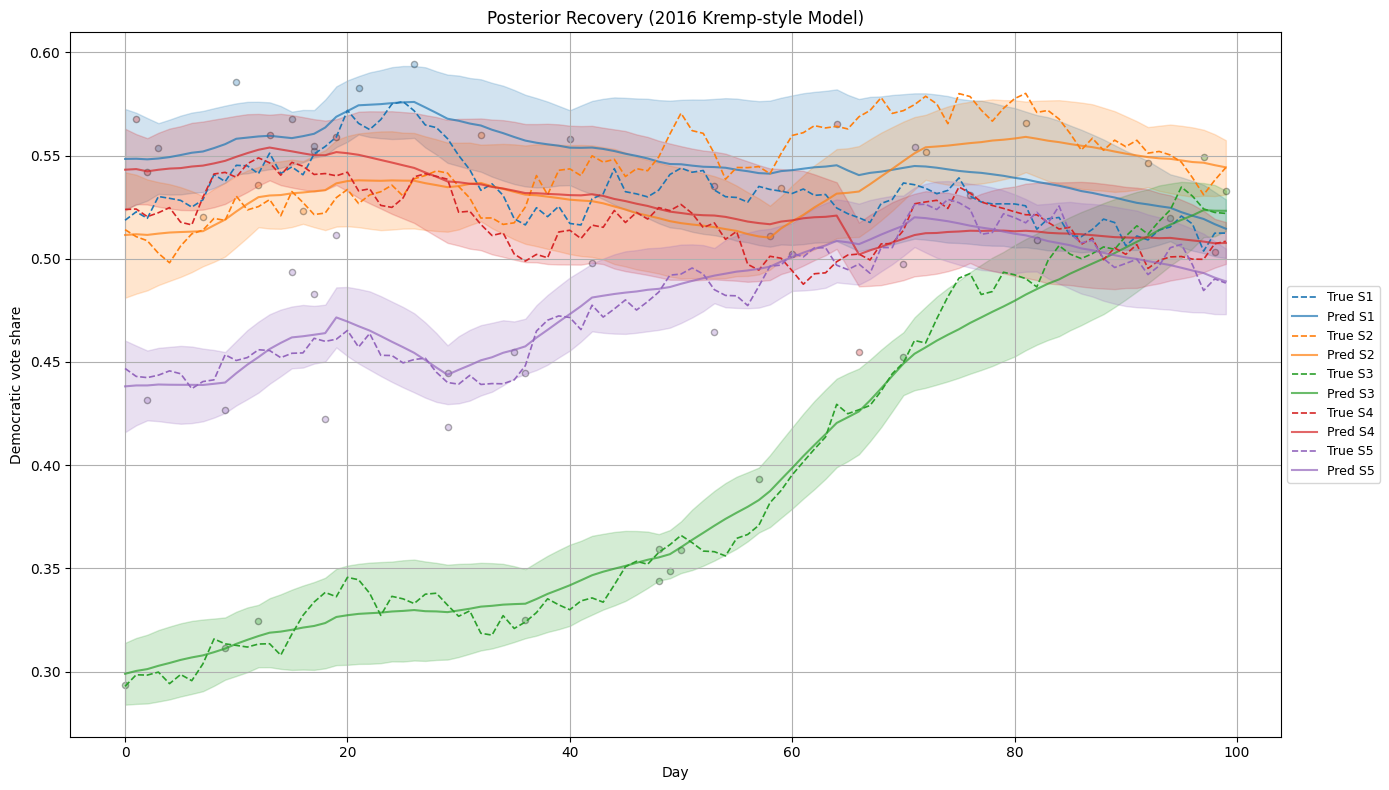

In [59]:
# Visualization

def plot_recovery_with_polls(
    pi_samples, mean_pi, std_pi, true_pi,
    state_idx, day_idx, y, n,
    title="Posterior Recovery (2016 Kremp-style Model)"
):
    S, T = mean_pi.shape
    poll_pi = y / n
    cmap = cm.get_cmap("tab10")

    plt.figure(figsize=(14, 8))
    for s in range(S):
        base_color = cmap(s % 10)

        # Plot true vs inferred
        plt.plot(true_pi[s], '--', linewidth=1.2, color=base_color, label=f"True S{s+1}")
        plt.plot(mean_pi[s], '-', color=base_color, alpha=0.7, label=f"Pred S{s+1}")
        plt.fill_between(
            np.arange(T),
            mean_pi[s] - std_pi[s],
            mean_pi[s] + std_pi[s],
            color=base_color,
            alpha=0.2
        )

        # Polls for this state
        mask = (state_idx == s)
        plt.scatter(
            day_idx[mask],
            poll_pi[mask],
            color=base_color,
            alpha=0.3,
            edgecolor='k',
            s=20,
            label=None  # suppress duplicate legend entries
        )

    plt.xlabel("Day")
    plt.ylabel("Democratic vote share")
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_recovery_with_polls(
    pi_samples=pi_samples,
    mean_pi=mean_pi,
    std_pi=std_pi,
    true_pi=true_pi,
    state_idx=state_idx,
    day_idx=day_idx,
    y=y,
    n=n
)


# Compare original and Kremp

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from cmdstanpy import CmdStanModel

# === Assumes you've already defined or loaded these ===
# - state_idx, day_idx, pollster_idx, n, y, h, tau, mu_a, mu_b, e
# - compiled_models (with "normal_02" Linzer model)
# - kremp_model (CmdStanModel for the Kremp-style Stan code)

S = 5
T = 100
P = 5

# Shared data
linzer_data = {
    "K": len(y),
    "J": T,
    "S": S,
    "state": (state_idx + 1).tolist(),
    "day": (day_idx + 1).tolist(),
    "n": list(n),
    "y": list(y),
    "h": h.tolist(),
    "tau": tau.tolist()
}

kremp_data = {
    "K": len(y),
    "T": T,
    "S": S,
    "P": P,
    "state": (state_idx + 1).tolist(),
    "day": (day_idx + 1).tolist(),
    "pollster": (pollster_idx + 1).tolist(),
    "n": list(n),
    "y": list(y),
    "h": h.tolist(),
    "tau": tau.tolist()
}

# Fit both models
linzer_fit = compiled_models["normal_02"].sample(
    data=linzer_data, chains=4, iter_sampling=500, iter_warmup=500
)

kremp_fit = kremp_model.sample(
    data=kremp_data, chains=4, iter_sampling=500, iter_warmup=500
)

# Extract posterior means
linzer_pi = np.mean(linzer_fit.stan_variable("pi"), axis=0)
kremp_pi = np.mean(kremp_fit.stan_variable("pi"), axis=0)

# Ground truth
true_pi = 1 / (1 + np.exp(-(mu_a[:, None] + mu_b + e[None, :])))
true_pi = true_pi.T  # Shape: (S, T)

DEBUG:cmdstanpy:cmd: /content/poll_model_normal_02 info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1v99qa0u/i0u7sjws.json
05:14:05 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:CmdStan args: ['/content/poll_model_normal_02', 'id=1', 'random', 'seed=3573', 'data', 'file=/tmp/tmp1v99qa0u/i0u7sjws.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_model_normal_02uve7477q/poll_model_normal_02-20250508051405_1.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/poll_model_normal_02', 'id=2', 'random', 'seed=3573', 'data', 'file=/tmp/tmp1v99qa0u/i0u7sjws.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_model_normal_02uve7477q/poll_model_normal_02-20250508051405_2.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/poll_model_normal_02', 'id=3', 'random', 'seed=3573', 'data', 'file

05:16:27 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/poll_model_normal_02', 'id=1', 'random', 'seed=3573', 'data', 'file=/tmp/tmp1v99qa0u/i0u7sjws.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_model_normal_02uve7477q/poll_model_normal_02-20250508051405_1.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp1v99qa0u/poll_model_normal_02uve7477q/poll_model_normal_02-20250508051405_1.csv
 console_msgs (if any):
	/tmp/tmp1v99qa0u/poll_model_normal_02uve7477q/poll_model_normal_02-20250508051405_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 500
    num_warmup = 500
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Defau

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/poll_model_kremp', 'id=1', 'random', 'seed=56596', 'data', 'file=/tmp/tmp1v99qa0u/5tl50qyj.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_model_krempkpwwveiv/poll_model_kremp-20250508051627_1.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/poll_model_kremp', 'id=2', 'random', 'seed=56596', 'data', 'file=/tmp/tmp1v99qa0u/5tl50qyj.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_model_krempkpwwveiv/poll_model_kremp-20250508051627_2.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/poll_model_kremp', 'id=3', 'random', 'seed=56596', 'data', 'file=/tmp/tmp1v99qa0u/5tl50qy

05:18:53 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/poll_model_kremp', 'id=1', 'random', 'seed=56596', 'data', 'file=/tmp/tmp1v99qa0u/5tl50qyj.json', 'output', 'file=/tmp/tmp1v99qa0u/poll_model_krempkpwwveiv/poll_model_kremp-20250508051627_1.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp1v99qa0u/poll_model_krempkpwwveiv/poll_model_kremp-20250508051627_1.csv
 console_msgs (if any):
	/tmp/tmp1v99qa0u/poll_model_krempkpwwveiv/poll_model_kremp-20250508051627_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 500
    num_warmup = 500
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
      gamma = 0.05 (Def

05:18:53 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 18 iterations at max treedepth (3.6%)
	Chain 2 had 17 iterations at max treedepth (3.4%)
	Chain 3 had 26 divergent transitions (5.2%)
	Chain 3 had 51 iterations at max treedepth (10.2%)
	Chain 4 had 2 divergent transitions (0.4%)
	Chain 4 had 14 iterations at max treedepth (2.8%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
	Chain 1 had 18 iterations at max treedepth (3.6%)
	Chain 2 had 17 iterations at max treedepth (3.4%)
	Chain 3 had 26 divergent transitions (5.2%)
	Chain 3 had 51 iterations at max treedepth (10.2%)
	Chain 4 had 2 divergent transitions (0.4%)
	Chain 4 had 14 iterations at max treedepth (2.8%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


<ipython-input-61-db811062ca16>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10")


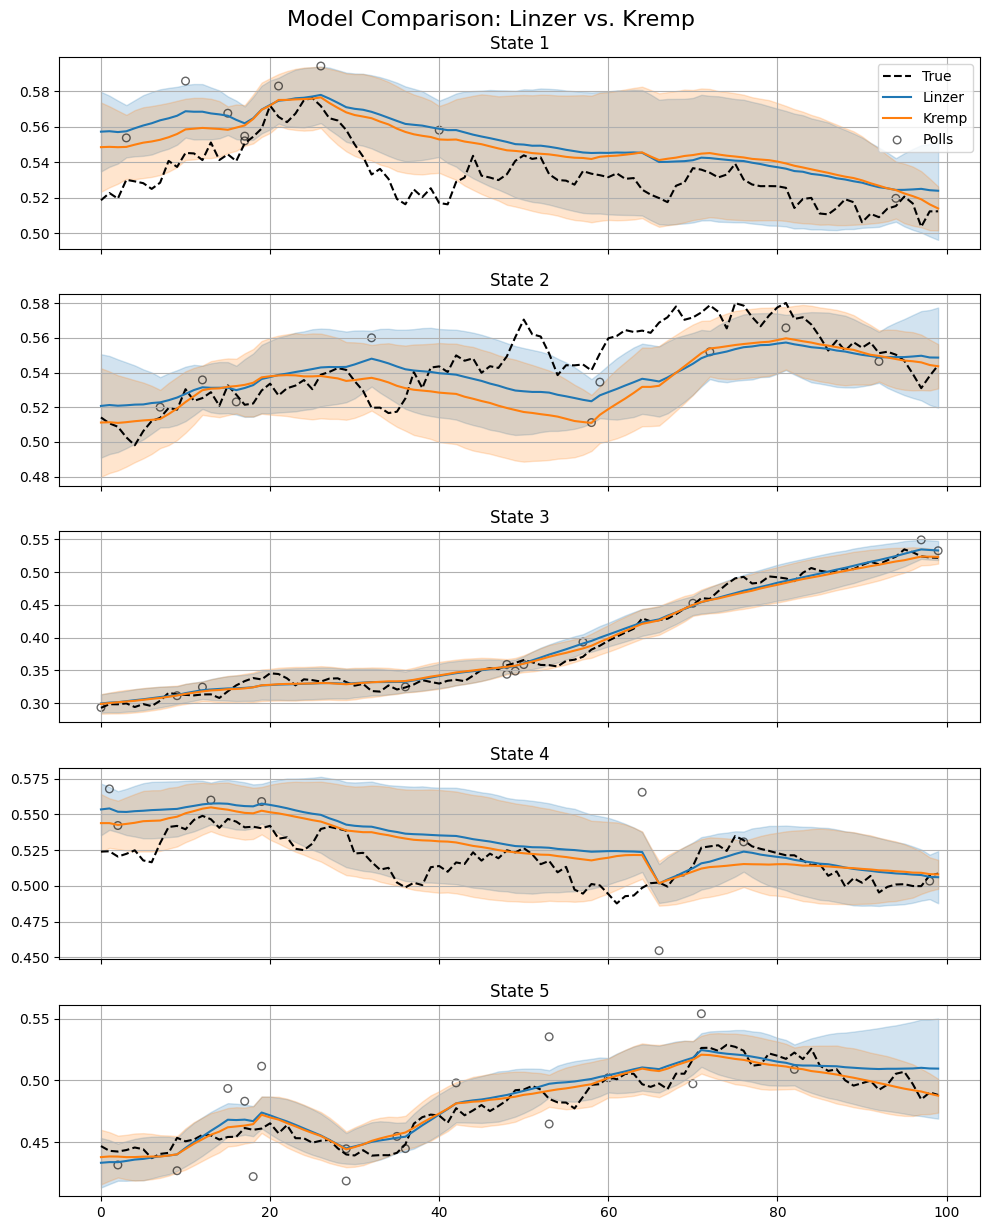

In [61]:
def plot_model_comparison(true_pi, linzer_pi, kremp_pi,
                          linzer_std=None, kremp_std=None,
                          state_idx=None, day_idx=None, y=None, n=None,
                          title_suffix=""):
    S, T = true_pi.shape
    cmap = cm.get_cmap("tab10")
    fig, axs = plt.subplots(S, 1, figsize=(10, 2.5 * S), sharex=True)

    poll_pi = y / n if y is not None and n is not None else None
    state_idx = np.array(state_idx) if state_idx is not None else None
    day_idx = np.array(day_idx) if day_idx is not None else None

    for s in range(S):
        ax = axs[s]
        ax.plot(true_pi[s], '--', label="True", color="black")

        # Linzer mean and uncertainty
        ax.plot(linzer_pi[s], label="Linzer", color=cmap(0))
        if linzer_std is not None:
            ax.fill_between(
                np.arange(T),
                linzer_pi[s] - linzer_std[s],
                linzer_pi[s] + linzer_std[s],
                color=cmap(0), alpha=0.2
            )

        # Kremp mean and uncertainty
        ax.plot(kremp_pi[s], label="Kremp", color=cmap(1))
        if kremp_std is not None:
            ax.fill_between(
                np.arange(T),
                kremp_pi[s] - kremp_std[s],
                kremp_pi[s] + kremp_std[s],
                color=cmap(1), alpha=0.2
            )

        # Polls
        if poll_pi is not None and state_idx is not None:
            mask = (state_idx == s)
            ax.scatter(
                day_idx[mask],
                poll_pi[mask],
                edgecolor='k',
                facecolor='none',
                s=30,
                alpha=0.6,
                label="Polls" if s == 0 else None
            )

        ax.set_title(f"State {s+1}")
        ax.grid(True)

    axs[0].legend()
    plt.suptitle(f"Model Comparison: Linzer vs. Kremp {title_suffix}", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_model_comparison(
    true_pi=true_pi,
    linzer_pi=np.mean(linzer_fit.stan_variable("pi"), axis=0),
    kremp_pi=np.mean(kremp_fit.stan_variable("pi"), axis=0),
    linzer_std=np.std(linzer_fit.stan_variable("pi"), axis=0),
    kremp_std=np.std(kremp_fit.stan_variable("pi"), axis=0),
    state_idx=state_idx,
    day_idx=day_idx,
    y=y,
    n=n
)